## Imports

In [39]:
import numpy as np
import tensorflow as tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import random

## Utility functions

In [37]:
def create_pairs(x, digit_indices):
    """Positive and negative pair creation.
    Alternates between positive and negative pairs.
    """
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

# Load data

In [40]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0 

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

Checking samples below

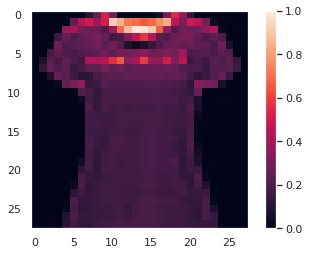

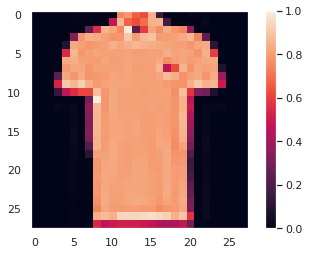

1.0


In [46]:
this_pair = 8

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(ts_y[this_pair])

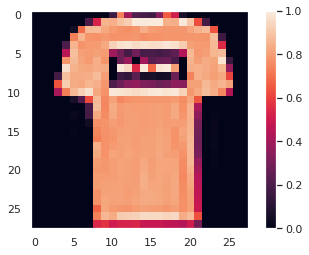

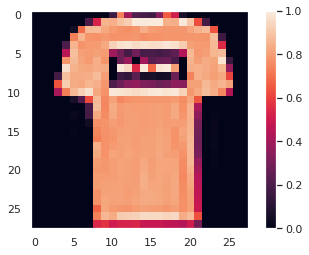

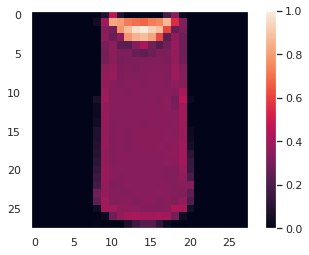

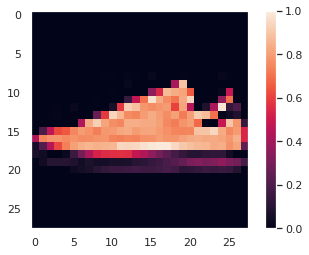

In [43]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Create Model

In [28]:
def initialize_base_network():
    inputs = Input(shape=(28, 28), name='Input_Layer')
    
    x = Flatten(name='flatten_input')(inputs)
    x = Dense(128, activation='relu', name='first_base_dense')(x)
    x = Dropout(0.1, name='first_dropout')(x)
    x = Dense(128, activation='relu', name='second_base_dense')(x)
    x = Dropout(0.1, name='second_dropout')(x)
    x = Dense(128, activation='relu', name='third_base_dense')(x)
    
    return Model(inputs=inputs, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape_1, shape_2 = shapes
    return (shape_1[0], 1)

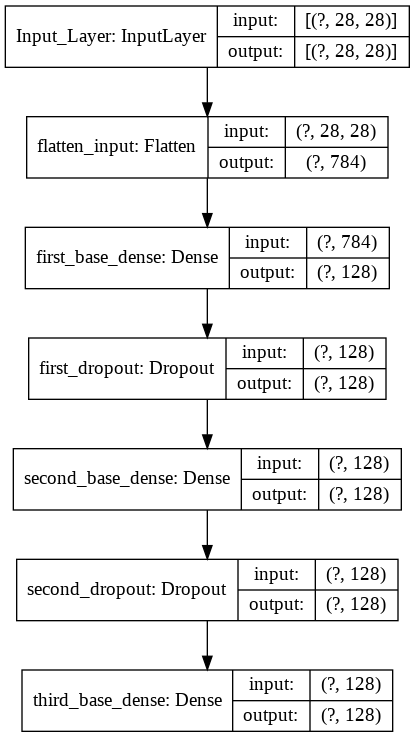

In [29]:
# initialize base network
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True)

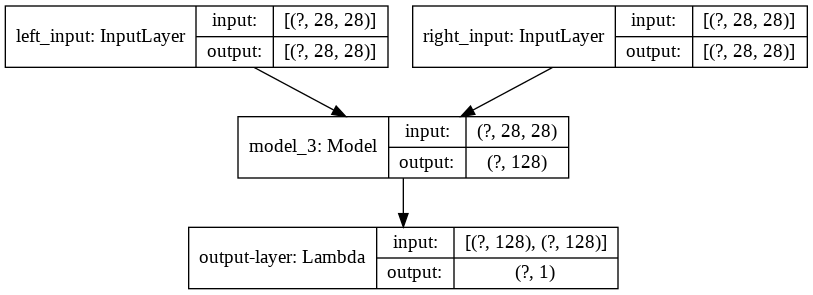

In [35]:
# create the left input and point to the base network
input_a = Input(shape=(28, 28), name='left_input')
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28, 28), name='right_input')
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name='output-layer', output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model(inputs=[input_a, input_b], outputs=output)
plot_model(model, show_shapes=True)

In [48]:
# define custom loss, Contrastive loss
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [50]:
rms = RMSprop()
model.compile(optimizer=rms, loss=contrastive_loss_with_margin(margin=1))

history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, 
                    epochs=20, batch_size=128, 
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Train on 119980 samples, validate on 19980 samples
Epoch 1/20
119980/119980 [==============================] - 9s 75us/sample - loss: 0.1098 - val_loss: 0.0863
Epoch 2/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0802 - val_loss: 0.0804
Epoch 3/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0712 - val_loss: 0.0721
Epoch 4/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0654 - val_loss: 0.0712
Epoch 5/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0625 - val_loss: 0.0689
Epoch 6/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0603 - val_loss: 0.0730
Epoch 7/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0591 - val_loss: 0.0653
Epoch 8/20
119980/119980 [==============================] - 8s 68us/sample - loss: 0.0573 - val_loss: 0.0681
Epoch 9/20
119980/119980 [==============================] - 8s 67us/sample - 

## Model Evaluation

In [51]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(y_true == pred)

In [57]:
loss = model.evaluate(x=[ts_pairs[:,0], ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = %f, Train accuracy = %f, Test accuracy = %f" % (loss, train_accuracy, test_accuracy))

19980/19980 [==============================] - 1s 36us/sample - loss: 0.0648
Loss = 0.064829, Train accuracy = 0.939248, Test accuracy = 0.913113


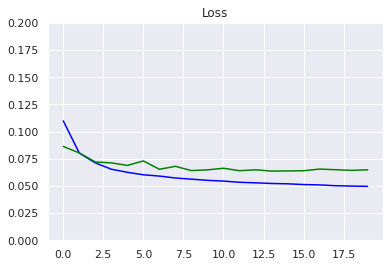

In [60]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    hist = history.history
    plt.plot(hist[metric_name], color='blue', label=metric_name)
    plt.plot(hist['val_' + metric_name], color='green', label='val_' + metric_name)
    
plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [61]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



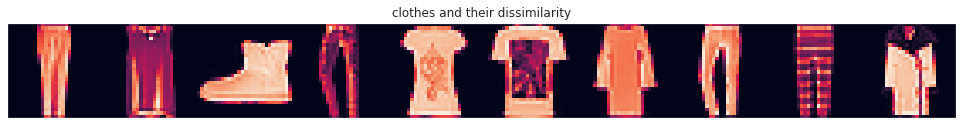

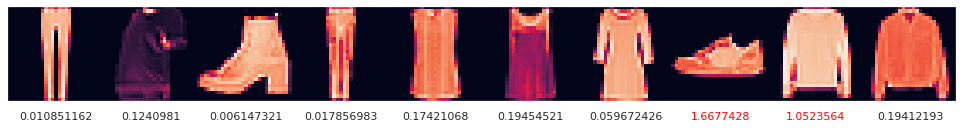

In [62]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)